<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/TransferLearning_preprocess_autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Elaborado por Nicolás Pavón npavong@unal.edu.co y Andrés Álvarez amalvarezme@unal.edu.co .

# Transfer Learning (Transferencia de aprendizaje)

- $\textbf{Transfer Learning}$, nos permite el entramineto de redes neuronales profundas con la ventaja de usar menos datos para la tarea que queremos realizar.

- Por lo tanto estamos $\textbf{trasnfiriendo}$ el $\textbf{"Conocimiento"}$ aprendido por el modelo en anteriores tareas (utilizando bases de datos grandes) a nuestro modelo nuevo (depurado sobre bases de datos más pequeñas).

- La idea general del transfer learning consta en aprovechar los modelos y sus parámetros entrenados, tomarlos para resolver nuestras propias tareas


# Clasificación de imagenes con Redes Neuronales Convolucionales (CNN's)

- Como tarea vamos a realizar la clasificación de imagenes mediante CNN's utilizando las librerias de Tensorflow y Keras.

- Nuestro dataset [Cifar10] (https://www.cs.toronto.edu/~kriz/cifar.html) lo importaremos de Keras.datasets

- El conjunto de datos CIFAR-10 consta de 60.000 fotos divididas en 10 clases. Las clases incluyen objetos comunes como aviones, automóviles, aves, gatos, etc. en. El conjunto de datos se divide de forma estándar, donde se utilizan 50.000 imágenes para la formación de un modelo y los 10.000 restantes para evaluar su desempeño. Las imágenes están en RGB de 32 x 32 píxeles.

Tengamos a la mano funciones que nos ayuden a graficar tanto en escala RGB como en escala de grises.

In [0]:
def plot_image(img):
    plt.imshow(img, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(img):
    plt.imshow(img, interpolation="nearest")
    plt.axis("off")

def crop(images):
    return images[150:220, 130:250]

1. Importemos las librerias TensorFlow y Keras

In [0]:
## instalamos los paquetes de tensorflow y keras
#!pip install tensorflow
#!pip install Keras
# Google colab, ya cuenta con la version más reciente de Tensorflow y Keras

In [0]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

2. El conjunto de datos $\textbf{Cifar10}$ lo importaremos de Keras.

    - El conjunto de datos CIFAR-10 consta de 60.000 fotos divididas en 10 clases. Las clases incluyen objetos comunes como aviones, automóviles, aves, gatos, etc. en. El conjunto de datos se divide de forma estándar, donde se utilizan 50.000 imágenes para la formación de un modelo y los 10.000 restantes para evaluar su desempeño. Las imágenes están en los 3 canales (rojo, verde y azul) y son cuadrados pequeños que miden 32 x 32 píxeles.

    - El dataset cifar10 ya se encuentra divido en los conjuntos de train y test

In [0]:
X_data = keras.datasets.cifar10

(X_train_full, y_train_full),(X_test, y_test) = X_data.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
X_train_full.shape

(50000, 32, 32, 3)

In [0]:
X_train_full.dtype

dtype('uint8')

- Se puede ver que el conjunto de entrenamineto contiene 50.000 imágenes en los 3 canales, cada imagen de 32x32 píxeles

- Vamos a escalar la intesidad de los píxeles para tenerlas en un rango de 0-1, además de convertirlas en flotantes. Es de buena práctica trabajar con datos normalizados.

In [0]:
X_valid, X_train = (X_train_full[:4000])/255.0 , (X_train_full[4000:])/255.0
X_test = X_test/255
y_valid, y_train = y_train_full[:4000], y_train_full[4000:]

In [0]:
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)

Training data shape :  (46000, 32, 32, 3) (46000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


Podemos visuzalizar las imagenes dentro del conjunto usando la funcion imshow() del paquete Matplotlib

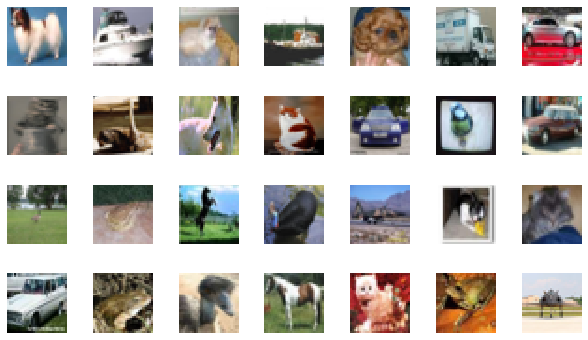

In [0]:
rows = 4
cols = 7
plt.figure(figsize=(cols * 1.5, rows * 1.5))
for row in range(rows):
    for col in range(cols):
        index = cols * row + col
        plt.subplot(rows, cols, index + 1)
        plt.imshow(X_train[index], interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Al tener modelos pre-entrenados, probablemente las imágenes que vamos a 
trabajar tienen un tamaño que no coincide con lo establecido para el modelo, veamos una función de **keras.layers**, por lo que cuando creemos el modelo vamos a ver cómo se podría agregar esta capa por si necesitamos ajustar el tamaño de imagen del **dataset**

In [0]:
original_size = X_train.shape[1:]
W = 64
H = 64
new_size = (W, H)
# Creemos una función Lambda por si tenemos problemas en el tamaño de las imágenes
input_ = keras.layers.Input(shape=original_size)
output = keras.layers.Lambda(lambda image: tf.image.resize(image, new_size))(input_)
model_resize = keras.models.Model(input=input_, output=output)

In [0]:
img_resize = model_resize.predict(X_train[np.newaxis, 2,:,:])

In [0]:
img_resize.shape

(1, 64, 64, 3)

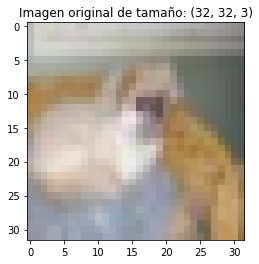

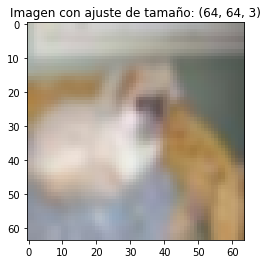

In [0]:
plt.imshow(X_train[2,:,:])
plt.title('Imagen original de tamaño: {}'.format(X_train.shape[1:]))
plt.show()
plt.imshow(img_resize[0,:,:,:])
plt.title('Imagen con ajuste de tamaño: {}'.format(img_resize.shape[1:]))
plt.show()

## 3. Arquitectura CNN

## Trasnfer learning con modelo pre-entrenado para la extracción de característcias.

- Para este otro ejercicio vamos a aplicar algo del *trasnfer Learning*:
  - Vamos a usar el modelo en keras **ResNet50**

  - Para implementar *transfer learning*, vamos a remover la última capa de predicción del model ResNet(podemos ver en la figura) y la remplazamos con nuestras propias capas.

  - Los pesos del modelo pre-entrenado se utilizan para la extracción de caraterísticas.

  - Los pesos del modelo pre-entrenado quedan 'congelados' y no se actualizan durante el entrenamiento 

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout #con el paquete tf.keras molesta con los shapes

model_pre_Res = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3), classes = 10)
model_pre_VGG = VGG16(include_top=False,  weights='imagenet', input_shape=(32, 32, 3), classes = 10)

# Apaguemos unas capas del modelo
layer_Res = model_pre_Res.layers
for i in range(15,30):
  layer_Res[i].trainable = False

layer_VGG = model_pre_VGG.layers
for i in range(1,5):
  layer_VGG[i].trainable = False


#secuencial    

model_Res = Sequential([
    model_pre_Res,
    Flatten(),
    Dense(units=1024, activation='relu', input_dim=[32,32,3]),
    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=10, activation='softmax')
])

model_VGG = Sequential([
    model_pre_VGG,
    Flatten(),
    Dense(units=1024, activation='relu', input_dim=[32,32,3]),
    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=10, activation='softmax')
])


'''
#funcional
#flat1_Res = Flatten()(model_pre_Res.layers[-1])
#flat1_VGG = Flatten()(model_pre_VGG.layers[-1])
f1 = Flatten()(model_pre_VGG.get_output_at(0))
h1 = Dense(1024, activation='relu', input_dim=[32,32,3])(f1)
h2 = Dense(512, activation='relu')(h1)
h3 = Dense(256, activation='relu')(h2)
d1 = Dropout(0.3)(h3)
h4 = Dense(128, activation='relu')(d1)
d2 = Dropout(0.2)(h4)
output = Dense(10, activation='softmax')(d2)
# define new model
model_VGG = Model(inputs=model_pre_VGG.inputs, outputs=output)
'''




58892288/58889256 [==============================] - 2s 0us/step


"\n#funcional\n#flat1_Res = Flatten()(model_pre_Res.layers[-1])\n#flat1_VGG = Flatten()(model_pre_VGG.layers[-1])\nf1 = Flatten()(model_pre_VGG.get_output_at(0))\nh1 = Dense(1024, activation='relu', input_dim=[32,32,3])(f1)\nh2 = Dense(512, activation='relu')(h1)\nh3 = Dense(256, activation='relu')(h2)\nd1 = Dropout(0.3)(h3)\nh4 = Dense(128, activation='relu')(d1)\nd2 = Dropout(0.2)(h4)\noutput = Dense(10, activation='softmax')(d2)\n# define new model\nmodel_VGG = Model(inputs=model_pre_VGG.inputs, outputs=output)\n"

### summarize

In [0]:
model_Res.summary()
#tf.keras.utils.plot_model(model_Res,show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [0]:
model_VGG.summary()
#tf.keras.utils.plot_model(model_VGG,show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

Analicemos cada línea de código del modelo:

- Hemos creado nuestor modelo usando transfer learning con ayuda del modelo pre-entrenado ResNet50, que si vemos ya tiene incluidas las capas de *flatten()*,*(Conv2D)* y las que hubieramos añadido a nuestro nuevo modelo.


- Luego está la red totalmente conectada (Fully-connected), compuesta de 4 capas densas, **3 ocultas** y **1 de salida**. Tenga en cuenta que **debemos aplanar sus entradas**, ya que una red densa espera una matriz 1D de características para cada instancia. También agregamos dos capas de *dropout*, con una tasa del $30\%$ y $20\%$ 

#### 4. Compilamos y ajustamos el modelo.


In [0]:
model_Res.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])
model_VGG.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])

In [0]:
print(model_Res.input_shape)
X_train.shape
X_valid.shape
#y_train.shape
zz = model_pre_Res.predict(X_train[:30])
print(zz.shape)
model_pre_Res.outputs

(None, 32, 32, 3)
(30, 1, 1, 2048)


[<tf.Tensor 'activation_49/Relu:0' shape=(None, 1, 1, 2048) dtype=float32>]

In [0]:
print(model_VGG.input_shape)
X_train.shape
X_valid.shape
#y_train.shape
zz = model_pre_VGG.predict(X_train[:30])
print(zz.shape)
model_pre_VGG.outputs

(None, 32, 32, 3)
(30, 1, 1, 512)


[<tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 1, 1, 512) dtype=float32>]

In [0]:
# Entrenemo el modelo para ResNET50
hist_Res = model_Res.fit(X_train, y_train, epochs=25,
                 validation_data=(X_valid, y_valid), batch_size=32)

Train on 46000 samples, validate on 4000 samples
Epoch 1/25
46000/46000 [==============================] - 106s 2ms/step - loss: 1.3890 - accuracy: 0.5170 - val_loss: 1.0972 - val_accuracy: 0.6308
Epoch 2/25
46000/46000 [==============================] - 94s 2ms/step - loss: 0.8794 - accuracy: 0.7127 - val_loss: 0.8248 - val_accuracy: 0.7293
Epoch 3/25
46000/46000 [==============================] - 93s 2ms/step - loss: 0.6833 - accuracy: 0.7754 - val_loss: 0.8704 - val_accuracy: 0.7092
Epoch 4/25
46000/46000 [==============================] - 92s 2ms/step - loss: 0.5570 - accuracy: 0.8169 - val_loss: 0.8750 - val_accuracy: 0.7105
Epoch 5/25
46000/46000 [==============================] - 91s 2ms/step - loss: 0.4539 - accuracy: 0.8504 - val_loss: 0.9165 - val_accuracy: 0.7122
Epoch 6/25
46000/46000 [==============================] - 90s 2ms/step - loss: 0.3790 - accuracy: 0.8741 - val_loss: 0.8910 - val_accuracy: 0.7255
Epoch 7/25
46000/46000 [==============================] - 90s 2ms/st

In [0]:
# Entrenemos el modelo para VGG16
hist_VGG = model_VGG.fit(X_train, y_train, epochs=25,
                 validation_data=(X_valid, y_valid), batch_size=32)

Train on 46000 samples, validate on 4000 samples
Epoch 1/25
46000/46000 [==============================] - 27s 593us/step - loss: 1.2477 - accuracy: 0.5734 - val_loss: 0.7622 - val_accuracy: 0.7385
Epoch 2/25
46000/46000 [==============================] - 27s 576us/step - loss: 0.7160 - accuracy: 0.7657 - val_loss: 0.5890 - val_accuracy: 0.8085
Epoch 3/25
46000/46000 [==============================] - 26s 575us/step - loss: 0.5536 - accuracy: 0.8190 - val_loss: 0.5861 - val_accuracy: 0.8055
Epoch 4/25
46000/46000 [==============================] - 26s 573us/step - loss: 0.4463 - accuracy: 0.8541 - val_loss: 0.5630 - val_accuracy: 0.8175
Epoch 5/25
46000/46000 [==============================] - 26s 575us/step - loss: 0.3613 - accuracy: 0.8819 - val_loss: 0.5714 - val_accuracy: 0.8227
Epoch 6/25
46000/46000 [==============================] - 26s 575us/step - loss: 0.2901 - accuracy: 0.9067 - val_loss: 0.5602 - val_accuracy: 0.8238
Epoch 7/25
46000/46000 [==============================] -

- Se eligió un pequeño número de épocas resolver esta tarea de forma rápida. Normalmente, el número de épocas sería entre dos o tres veces el valor escogido para resolver este tipo de tareas. 

In [0]:
score_Res = model_Res.evaluate(X_test, y_test, verbose=0)
score_VGG = model_VGG.evaluate(X_test, y_test, verbose=0)
print("Accuracy for ResNet50: %.2f%%" % (score_Res[1]*100))
print("Accuracy for VGG16: %.2f%%" % (score_VGG[1]*100))

Accuracy for ResNet50: 64.29%
Accuracy for VGG16: 84.82%


5. Por último hacemos nuestra predicción, en este caso vamos a pretender que tenemos una nuevas imagenes que tomaremos del conjunto X_test

In [0]:
X_new = X_test[:10] # New images
y_pred_Res = model_Res.predict(X_new)
y_pred_VGG = model_VGG.predict(X_new)

In [0]:
print(y_pred_Res)

[[6.6121184e-04 9.7430166e-05 9.8069097e-05 9.6413344e-01 4.1710897e-03
  6.4340868e-04 2.9952187e-04 1.5271603e-03 2.7551988e-02 8.1664580e-04]
 [8.7741770e-05 5.5061426e-04 2.1874930e-06 1.6195103e-06 6.6385309e-07
  1.3925353e-07 1.0460273e-06 4.2974710e-07 9.9933040e-01 2.5186166e-05]
 [2.6494844e-02 5.2396031e-03 1.2361041e-04 2.4133892e-04 2.1074098e-04
  3.2700660e-05 5.1556704e-05 7.7010191e-05 8.9065015e-01 7.6878414e-02]
 [9.6480656e-01 1.6829226e-05 2.0359045e-04 2.3280113e-04 3.9842547e-05
  2.3156799e-06 3.7066659e-06 2.7037124e-06 3.4536671e-02 1.5514200e-04]
 [1.7607281e-05 5.2219915e-05 5.7618495e-04 4.3876123e-04 3.0895230e-01
  2.9504927e-05 6.8981659e-01 4.6258458e-05 2.3033926e-05 4.7438032e-05]
 [2.0720011e-03 1.0705164e-02 3.1095655e-03 2.0216069e-01 1.2115354e-01
  3.3074711e-03 4.0548822e-01 4.0729968e-03 2.4402228e-01 3.9080768e-03]
 [1.9559371e-05 9.9708909e-01 1.1149265e-06 2.8335888e-04 2.7236767e-06
  7.8791072e-06 4.2226693e-05 1.7254270e-05 7.6563570e-05 

In [0]:
print(y_pred_VGG)

[[4.2737316e-05 3.0099671e-05 1.8247053e-04 6.7922711e-01 1.2526791e-04
  3.2011449e-01 1.2321319e-04 6.0164075e-05 3.4518722e-05 5.9800317e-05]
 [3.3010938e-04 4.1964155e-04 4.4071916e-05 3.1574673e-05 1.1321357e-05
  2.6750147e-05 2.5464407e-05 9.3759290e-06 9.9892491e-01 1.7668944e-04]
 [3.8527153e-03 2.7487439e-03 2.9981878e-04 3.1633701e-04 1.6096656e-04
  2.1421199e-04 1.9430649e-04 9.7501637e-05 9.9047464e-01 1.6407177e-03]
 [9.9799001e-01 7.6481403e-05 1.9125814e-04 7.0565904e-05 3.6690475e-05
  7.1518702e-06 6.2506087e-06 1.1215775e-05 1.5082418e-03 1.0215182e-04]
 [7.2671344e-07 1.0866974e-05 7.1621136e-05 3.6581441e-05 1.2267612e-04
  3.9035235e-06 9.9974781e-01 3.8789366e-07 2.4113951e-06 3.0427530e-06]
 [8.7451224e-07 3.0764975e-05 7.9788530e-05 1.6453200e-04 5.6148197e-05
  3.9852985e-05 9.9961829e-01 8.9438623e-07 2.6729924e-06 6.0108791e-06]
 [2.6862469e-06 9.9986303e-01 2.4524960e-08 3.9154071e-07 1.2751296e-08
  9.0047315e-08 1.0740781e-06 1.2992685e-07 3.7831069e-06 

- Guardemos el modelo, para hacer transfer learning, por si en el futuro necesitamos hacer otro clasificador.

In [0]:
model_Res.save("my_model_Res.h5py")
model_VGG.save("my_model_Res.h5py")

Otros formatos para guardar y cargar modelos de keras:

[save_load model keras](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

# Otras aplicaciones de transfer learning y visión con redes neuronales


[Semantic Segmentation](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

# Autodiff en keras

La clave de la eficiencia en redes con deep learning es el autodiff

[Autodiff](https://en.wikipedia.org/wiki/Automatic_differentiation)

In [0]:
#ejemplo simple de autodiff
#funcion a derivar
def f(w1,w2):
    return 3*w1**2 + 2 *w1*w2

  

In [0]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1+eps,w2)-f(w1,w2))/eps #estimacion numerica de la derivada

36.000003007075065

In [0]:
(f(w1,w2+eps)-f(w1,w2))/eps #

10.000000003174137

La aproximación numérica funciona bien pero debe llamarse $f(\cdot)$ para calcular el gradiente de cada variable, intratable para muchos parámetros en deep learning.

El gradient tape de tensorflow (autodiff) facilita los cálculos del gradiente y lo hace eficiente para grandes cantidades de parámetros

In [0]:
w1,w2 = tf.Variable(5.),tf.Variable(3.)
with tf.GradientTape() as tape: #crear contexto gradient tape para guardar cada operacion que envuelve una variable
    z=f(w1,w2) #funcion de perdida (loss) para salvar memoria colocar la menor cantidad de codigo en el tape

gradients = tape.gradient(z,[w1,w2]) # tape calcula  los gradientes del resultado z con respecto a [w1,w2]
gradients #gradient tape hace los calculos una sola vez de forma inversa sin importar la cantidad de variables

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

## Cuando se hace fit a un modelo secuencial o funcional en keras, utiliza gradient tape.

## Si se desea se pueden utilizar los gradientes de gradientTape y un paso personalizado fuera del ambiente model.fit() para problemas especializados sin necesidad de hacer el cálculo analítico de gradientes

## Para proyectos especializados ver:

[Custom training loop tf](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough)